In [24]:
import sys, os
from os.path import expanduser as eu
sys.path.append(eu('~/Git/pygwinc/'))
import gwinc
from gwinc.ifo.noises import *
import numpy as np
import scipy.constants as scc
import matplotlib as mpl
import matplotlib.pyplot as plt
# Load MPL style file
notLoaded = True
if notLoaded:
    mpl.style.use(eu('~/Git/40m/pygwinc/CIT40m/style40.mpl'))
    notLoaded = False
    
import pickle
from uncertainties import ufloat as uf
from uncertainties import unumpy as unp
from uncertainties.unumpy import nominal_values as unpnv
from uncertainties.unumpy import std_devs as unpstd
import uncertainties.core as uncore

from scipy.io import loadmat

In [25]:
freq = loadmat('LHO_NB_freq.mat')['freq'][0, :]

In [26]:
# Define the frequency bins [Hz]
#freq = np.logspace(1, 4, 5000)
LIGOL = gwinc.load_budget('aLIGO').ifo.Infrastructure.Length
# Load the 40m budget class
nbs = {}
for key in ['aLIGO', 'Aplus', 'Voyager']:
    nbs[key] = gwinc.load_budget(key)(freq).run()
    strain2disp = gwinc.load_budget(key).ifo.Infrastructure.Length
    
def Straintom(x):
    return x * strain2disp

def mtoStrain(x):
    return x / strain2disp

In [27]:
def calcTotal(nosbud):
    totNoise = np.zeros_like(freq)
    if 'Total' in nosbud:
        nosbud['Total'] = (nosbud['Total'][0],
                           {'label': 'Total', 'color': '#000000',
                            'linewidth': '8', 'linestyle': '-'})
    else:
        for noise in nosbud:
            if noise not in ['Total', 'Measured Noise at Hanford', 'Others']:
                if isinstance(nosbud[noise], dict):
                    totNoise += nosbud[noise]['Total'][0]
                totNoise += nosbud[noise][0]
        nosbud['Total'] = (totNoise,
                           {'label': 'Total', 'color': '#000000',
                            'linewidth': '8', 'linestyle': '-'})

## Advanced LIGO Noise Budget

In [28]:
LHO_NB_O3a_shot = loadmat('LHO_NB_O3a_Shot_Noise.mat')['shotNoise'][0, :] / LIGOL
LHO_NB_O3a_rp = loadmat('LHO_NB_O3a_Rad_Press_Noise.mat')['radNoise'][0, :] / LIGOL
LHO_NB_O3a_DARM = loadmat('LHO_NB_O3a_DARM_Noise.mat')['DARMref'][0, :] / LIGOL
LHO_NB_O3a_Total = loadmat('LHO_NB_total.mat')['NBtotal'][0, :] / LIGOL

In [29]:
aLIGOnb = nbs['aLIGO']

aLIGOnb['OldQuantum'] = (aLIGOnb['QuantumVacuum'][0],
                         {'label': 'Old Quantum', 'linestyle': '--'})
aLIGOnb['QuantumVacuum'] = (LHO_NB_O3a_shot**2 + LHO_NB_O3a_rp**2,
                                 nbs['aLIGO']['QuantumVacuum'][1])
aLIGOnb['QuantumVacuum'][1]['label'] = 'Vacuum Quantum Noise'
aLIGOnb['CoatingBrownian'][1]['label'] = 'Coating Brownian Noise'

othNoise = np.zeros_like(freq)
for key in aLIGOnb:
    if key not in ['Total', 'QuantumVacuum', 'CoatingBrownian', 'OldQuantum',
                     'Others', 'Measured Noise at Hanford']:
        if isinstance(aLIGOnb[key], dict):
            othNoise += aLIGOnb[key]['Total'][0]
        else:
            othNoise += aLIGOnb[key][0]
#othNoise = LHO_NB_O3a_Total**2 - aLIGOnb['QuantumVacuum'][0] - aLIGOnb['CoatingBrownian'][0]

totNoise = np.zeros_like(freq)
for key in aLIGOnb:
    if key in ['QuantumVacuum', 'CoatingBrownian', 'Others']:
        if isinstance(aLIGOnb[key], dict):
            totNoise += aLIGOnb[key]['Total'][0]
        else:
            totNoise += aLIGOnb[key][0]

aLIGOnb['Total'] = (totNoise,
                    {'label': 'Total Noise', 'color': '#000000',
                     'linewidth': '8', 'linestyle': '-'})
aLIGOnb['Others'] = (othNoise,
                    {'label': 'Other Noise Sources', 'color': '#0d75f8',
                     'linewidth': '5', 'linestyle': '-'})
aLIGOnb['Measured Noise at Hanford'] = (LHO_NB_O3a_DARM**2,
                                        {'label': 'Measured Noise at LIGO Hanford', 'color': '#fb7d07',
                                         'linewidth': '5', 'linestyle': '-'})

Text(0, 0.5, 'Displacement Noise Amplitude Spectral Density [$m/\\sqrt{Hz}$]')

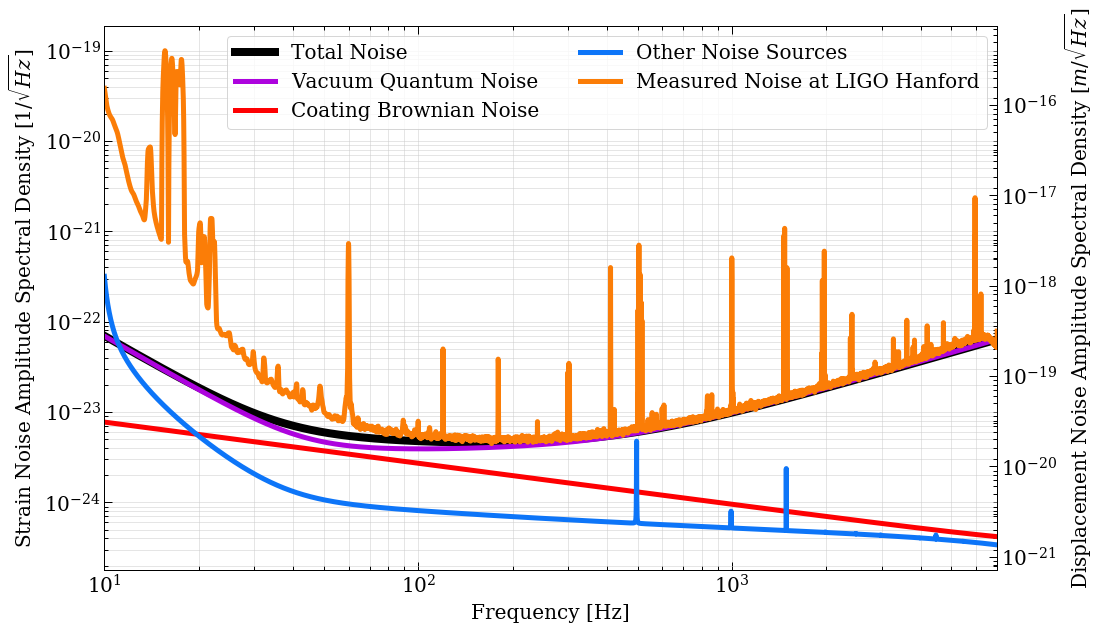

In [32]:
fig, ax = plt.subplots(1,1, figsize=(16,10))

# Title
# ax.set_title('Advanced LIGO Noise Budget')

# Noise curves
for key in ['Total', 'QuantumVacuum', 'CoatingBrownian', 'Others', 'Measured Noise at Hanford']:
    trace = aLIGOnb[key][0]**.5
    style = aLIGOnb[key][1]
    if 'linewidth' not in style:
        style['linewidth'] = 5
    ax.plot(freq, trace, **style)
    
# Plot formatting
ax.set_xlim([freq[0], freq[-1]])
#ax.set_ylim([1e-25, 2e-20])
ax.set_xlabel(u"Frequency [Hz]")
ax.set_ylabel("Strain Noise Amplitude Spectral Density [" + r'$1/\sqrt{Hz}$'+ ']')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(ncol=2);
ax.tick_params(right=False)
secaxy = ax.secondary_yaxis('right', functions=(Straintom, mtoStrain))
secaxy.set_ylabel("Displacement Noise Amplitude Spectral Density [" + r'$m/\sqrt{Hz}$'+ ']')

# Uncomment to save figure
#fig.savefig('aLIGO_NoiseBudget.pdf', bbox_inches='tight')

In [42]:
aLIGOnb['Newtonian']

(array([1.37950380e-045, 1.36732857e-045, 1.35522271e-045, ...,
        1.41613975e-296, 7.02904550e-297, 3.48573069e-297]),
 {'label': 'Newtonian Gravity', 'color': '#15b01a', 'linewidth': 5})

Text(0, 0.5, 'Displacement Noise Amplitude Spectral Density [$m/\\sqrt{Hz}$]')

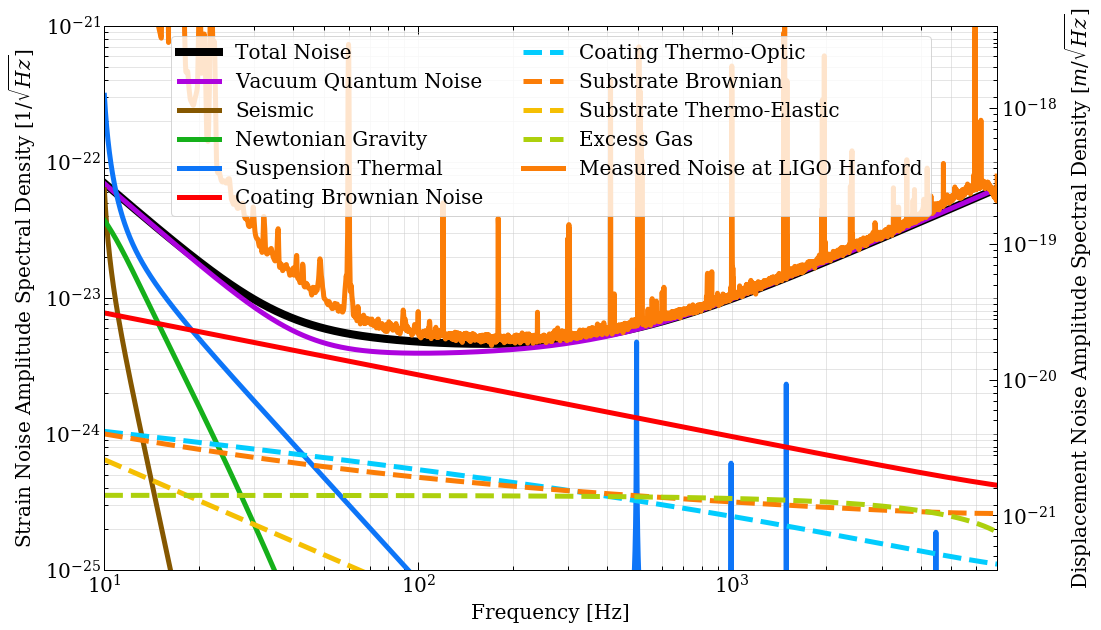

In [34]:
fig, ax = plt.subplots(1,1, figsize=(16,10))

# Title
# ax.set_title('Advanced LIGO Noise Budget')

# Noise curves
for key in aLIGOnb:
    if key not in ['Others', 'OldQuantum']:
        trace = aLIGOnb[key][0]**.5
        style = aLIGOnb[key][1]
        if 'linewidth' not in style:
            style['linewidth'] = 5
        ax.plot(freq, trace, **style)
    
# Plot formatting
ax.set_xlim([freq[0], freq[-1]])
ax.set_ylim([1e-25, 1e-21])
ax.set_xlabel(u"Frequency [Hz]")
ax.set_ylabel("Strain Noise Amplitude Spectral Density [" + r'$1/\sqrt{Hz}$'+ ']')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(ncol=2);
ax.tick_params(right=False)
secaxy = ax.secondary_yaxis('right', functions=(Straintom, mtoStrain))
secaxy.set_ylabel("Displacement Noise Amplitude Spectral Density [" + r'$m/\sqrt{Hz}$'+ ']')

# Uncomment to save figure
#fig.savefig('aLIGO_NoiseBudget_Full.pdf', bbox_inches='tight')

In [35]:
def coatBrGwinc(Budget, freq, dOpt_ETM=None):
    wavelength = Budget.ifo.Laser.Wavelength
    materials = Budget.ifo.Materials
    w0, wBeam_ITM, wBeam_ETM = arm_cavity(Budget.ifo)
    if dOpt_ETM is None:
        dOpt_ETM = coating_thickness(Budget.ifo, 'ETM')
    if 'IncCoatBrAmpNoise' in Budget.ifo.Materials.Coating:
        if Budget.ifo.Materials.Coating.IncCoatBrAmpNoise.lower() == 'yes':
            mTi_ITM = Budget.ifo.Optics.ITM.Transmittance
            mTi_ETM = Budget.ifo.Optics.ETM.Transmittance
            Ic = Budget.ifo.Laser.Power * Budget.ifo.gwinc.finesse / pi
            nETM = noise.coatingthermal.coating_brownian(
                freq, materials, wavelength, wBeam_ETM,
                dOpt_ETM, Ic, mTi_ETM)
    else:
        nETM = noise.coatingthermal.coating_brownian(
            freq, materials, wavelength, wBeam_ETM, dOpt_ETM)
    #return (nITM + nETM) * 2
    return nETM

In [36]:
aLIGO_AlGaAs = gwinc.load_budget('./aLIGO_AlGaAs/')

In [37]:
AlGaAs_dOpt = np.array([1.89535714e-01, 1.12057190e-01, 4.98451128e-01, 1.00026081e-01,
                        4.59693609e-01, 1.69414803e-01, 2.76045113e-01, 2.14601410e-01,
                        2.51024436e-01, 2.38803524e-01, 2.40394737e-01, 2.50414944e-01,
                        2.36796992e-01, 2.55311325e-01, 2.37451128e-01, 2.57129981e-01,
                        2.39250000e-01, 2.56430498e-01, 2.41375940e-01, 2.55031532e-01,
                        2.43665414e-01, 2.53212876e-01, 2.45954887e-01, 2.51534117e-01,
                        2.48080827e-01, 2.49855357e-01, 2.49716165e-01, 2.48176598e-01,
                        2.51351504e-01, 2.46917528e-01, 2.52823308e-01, 2.45658459e-01,
                        2.53968045e-01, 2.44679182e-01, 2.54949248e-01, 2.43839803e-01,
                        2.55603383e-01, 2.43280216e-01, 2.56257519e-01, 2.42720630e-01,
                        2.56584586e-01, 2.42300940e-01, 2.57075188e-01, 2.42021147e-01,
                        2.57402256e-01, 2.41601457e-01, 2.57729323e-01, 2.41321664e-01,
                        2.57892857e-01, 2.41181767e-01, 2.58056391e-01, 2.40901974e-01,
                        2.58546992e-01, 2.40482284e-01, 2.58710526e-01, 2.40062594e-01,
                        2.55603383e-01])
aLIGO_AlGaAs_coatBr = 4 * coatBrGwinc(aLIGO_AlGaAs, freq, dOpt_ETM=AlGaAs_dOpt) / LIGOL**2

Text(0, 0.5, 'Displacement Noise Amplitude Spectral Density [$m/\\sqrt{Hz}$]')

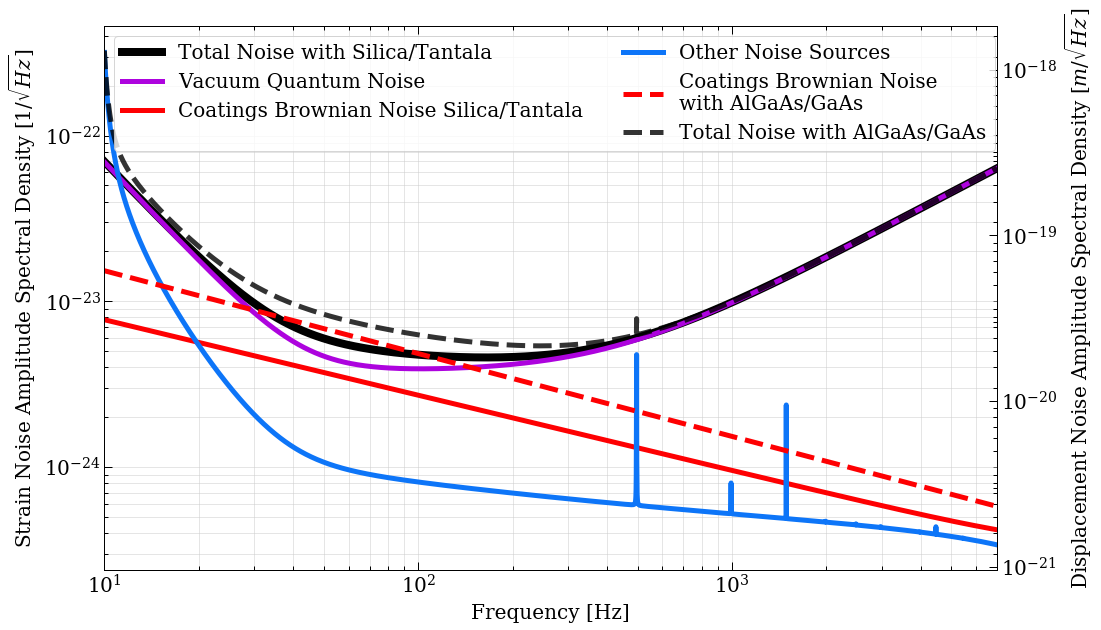

In [39]:
fig, ax = plt.subplots(1,1, figsize=(16,10))

# Title
# ax.set_title('Advanced LIGO Noise Budget')
aLIGOnb['CoatingBrownian'][1]['label'] = 'Coatings Brownian Noise Silica/Tantala'
aLIGOnb['Total'][1]['label'] = 'Total Noise with Silica/Tantala'
# Noise curves
for key in ['Total', 'QuantumVacuum', 'CoatingBrownian', 'Others']:
    trace = aLIGOnb[key][0]**.5
    style = aLIGOnb[key][1]
    if 'linewidth' not in style:
        style['linewidth'] = 5
    ax.plot(freq, trace, **style)

ax.plot(freq, aLIGO_AlGaAs_coatBr**.5, label='Coatings Brownian Noise\nwith AlGaAs/GaAs',
        color= '#fe0002', linewidth = 5, ls='--')

ax.plot(freq, 
        (aLIGO_AlGaAs_coatBr + aLIGOnb['Others'][0] + aLIGOnb['QuantumVacuum'][0])**.5 ,
        label='Total Noise with AlGaAs/GaAs',
        color= '#000000', linewidth = 5, ls='--', alpha=0.8)
# Plot formatting
ax.set_xlim([freq[0], freq[-1]])
#ax.set_ylim([1e-25, 2e-20])
ax.set_xlabel(u"Frequency [Hz]")
ax.set_ylabel("Strain Noise Amplitude Spectral Density [" + r'$1/\sqrt{Hz}$'+ ']')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(ncol=2);
ax.tick_params(right=False)
secaxy = ax.secondary_yaxis('right', functions=(Straintom, mtoStrain))
secaxy.set_ylabel("Displacement Noise Amplitude Spectral Density [" + r'$m/\sqrt{Hz}$'+ ']')

# Uncomment to save figure
#fig.savefig('aLIGO_Projected_NoiseBudget.pdf', bbox_inches='tight')

## Comparison with Future Detectors

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,10))

# Title
ax.set_title('Improvement with Future Gravitational Wave Detectors')

# Noise curves
key = 'aLIGO'
calcTotal(nbs[key])
trace = nbs[key]['Total'][0]**.5
ax.plot(freq, trace, linewidth=5, label='Advanced LIGO (Present)')
key = 'Aplus'
calcTotal(nbs[key])
trace = nbs[key]['Total'][0]**.5
ax.plot(freq, trace, linewidth=5, label='A+ LIGO (2025)')
key = 'Voyager'
calcTotal(nbs[key])
trace = nbs[key]['Total'][0]**.5
ax.plot(freq, trace, linewidth=5, label='Voyager (2028)')
    
# Plot formatting
ax.set_xlim([freq[0], freq[-1]])
#ax.set_ylim([1e-25, 1e-21])
ax.set_xlabel(u"Frequency [Hz]")
ax.set_ylabel("Strain Noise Amplitude Spectral Density [" + r'$1/\sqrt{Hz}$'+ ']', fontsize=26)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();
ax.tick_params(right=False)
secaxy = ax.secondary_yaxis('right', functions=(Straintom, mtoStrain))
secaxy.set_ylabel("Displacement Noise Amplitude Spectral Density [" + r'$m/\sqrt{Hz}$'+ ']')

# Uncomment to save figure
#fig.savefig('NoiseBudgetComparison.pdf', bbox_inches='tight')

## FSS OLTFs

In [ ]:
NorthData = np.loadtxt(eu('~/Git/cit_ctnlab/ctn_labdata/data/20200805_FSS_OLTFs/North_FSS_OLTF.txt'))
SouthData = np.loadtxt(eu('~/Git/cit_ctnlab/ctn_labdata/data/20200805_FSS_OLTFs/South_FSS_OLTF.txt'))

#Making OLTF without '-1' sign
NorthAngle = np.angle(np.exp(1j * (NorthData[:, 2] + 180) * np.pi / 180)) * 180 / np.pi
SouthAngle = np.angle(np.exp(1j * (SouthData[:, 2] + 180) * np.pi / 180)) * 180 / np.pi
ff = NorthData[:, 0]
fig, ax = plt.subplots(2,1, figsize=(16,10), sharex=True,
                       gridspec_kw={'hspace':0.05})

ax[0].loglog(ff, NorthData[:, 1], linewidth=5, label='North')
ax[0].loglog(ff, SouthData[:, 1], linewidth=5, label='South')

ax[1].semilogx(ff, NorthAngle, linewidth=5, label='North')
ax[1].semilogx(ff, SouthAngle, linewidth=5, label='South')

ax[0].legend()

ax[0].set_ylabel('Magnitude')
ax[1].set_ylabel(r'Phase [$^\circ$]')
ax[1].set_xlabel('Frequency [Hz]')

ax[0].set_yticks([0.1, 1, 10, 1e2, 1e3, 1e4, 1e5])
ax[1].set_yticks(np.arange(-180, 181, 90))

ax[0].set_title('Open loop transfer function for frequency stabilization servo')

#fig.savefig('FSS_OLTFs.pdf', bbox_inches='tight')

## PMC OLTFs

In [ ]:
NorthData = np.loadtxt(eu('~/Git/cit_ctnlab/ctn_labdata/data/20200811_PMC_OLTFs/NPMC_OLTF.txt'))
SouthData = np.loadtxt(eu('~/Git/cit_ctnlab/ctn_labdata/data/20200811_PMC_OLTFs/SPMC_OLTF.txt'))

#Making OLTF without '-1' sign
NorthAngle = np.angle(np.exp(1j * (NorthData[:, 2] + 180) * np.pi / 180)) * 180 / np.pi
SouthAngle = np.angle(np.exp(1j * (SouthData[:, 2] + 180) * np.pi / 180)) * 180 / np.pi

ff = NorthData[:, 0]
fig, ax = plt.subplots(2,1, figsize=(16,10), sharex=True,
                       gridspec_kw={'hspace':0.05})

ax[0].loglog(ff, NorthData[:, 1], linewidth=5, label='North')
ax[0].loglog(ff, SouthData[:, 1], linewidth=5, label='South')

ax[1].semilogx(ff, NorthAngle, linewidth=5, label='North')
ax[1].semilogx(ff, SouthAngle, linewidth=5, label='South')

ax[0].legend()

ax[0].set_ylabel('Magnitude')
ax[1].set_ylabel(r'Phase [$^\circ$]')
ax[1].set_xlabel('Frequency [Hz]')

ax[0].set_yticks([0.1, 1, 10, 1e2, 1e3, 1e4, 1e5])
ax[1].set_yticks(np.arange(-180, 181, 90))

ax[0].set_title('Open loop transfer function for pre-mode cleaner')

#fig.savefig('PMC_OLTFs.pdf', bbox_inches='tight')

## ISS OLTFs

In [ ]:
NorthData = np.loadtxt(eu('~/Git/cit_ctnlab/ctn_labdata/data/20200820_ISS_OLTF/NISS_OLTF_G2000.txt'))
SouthData = np.loadtxt(eu('~/Git/cit_ctnlab/ctn_labdata/data/20200820_ISS_OLTF/SISS_OLTF_G5000.txt'))

#Making OLTF without '-1' sign
NorthAngle = np.angle(np.exp(1j * (NorthData[:, 2] + 180) * np.pi / 180)) * 180 / np.pi
SouthAngle = np.angle(np.exp(1j * (SouthData[:, 2] + 180) * np.pi / 180)) * 180 / np.pi

ff = NorthData[:, 0]
fig, ax = plt.subplots(2,1, figsize=(16,10), sharex=True,
                       gridspec_kw={'hspace':0.05})

ax[0].loglog(ff, NorthData[:, 1], linewidth=5, label='North')
ax[0].loglog(ff, SouthData[:, 1], linewidth=5, label='South')

ax[1].semilogx(ff, NorthAngle, linewidth=5, label='North')
ax[1].semilogx(ff, SouthAngle, linewidth=5, label='South')

ax[0].legend()

ax[0].set_ylabel('Magnitude')
ax[1].set_ylabel(r'Phase [$^\circ$]')
ax[1].set_xlabel('Frequency [Hz]')

ax[1].set_yticks(np.arange(-180, 181, 90))

ax[0].set_title('Open loop transfer function for intensity stabilization servo')

#fig.savefig('ISS_OLTFs.pdf', bbox_inches='tight')

## Silicon Absorption Plot

Data from [M. A. Green, Solar Energy Materials & Solar Cells 92 (2008) 1305–1310](https://doi.org/10.1016/j.solmat.2008.06.009)

In [ ]:
wavelength = np.arange(240e-9, 1450e-9, 10e-9)

# Tabulated abs coefficients from [1]
alpha = np.array([1.84e6, 1.97e6, 2.18e6, 2.37e6, 2.29e6,
                  1.77e6, 1.46e6, 1.3e6, 1.18e6, 1.10e6,
                  1.06e6, 1.04e6, 7.37e5, 3.13e5, 1.43e5,
                  9.3e4, 6.95e4, 5.27e4, 4.02e4, 3.07e4,
                  2.41e4, 1.95e4, 1.66e4, 1.44e4, 1.26e4,
                  1.11e4, 9.7e3, 8.8e3, 7.85e3, 7050, 
                  6390, 5780, 5320, 4880, 4490, 
                  4175, 3800, 3520, 3280, 3030, 
                  2790, 2570, 2390, 2200, 2040,
                  1890, 1780, 1680, 1540, 1420,
                  1310, 1190, 1100, 1030, 928,
                  850, 775, 707, 647, 590, 
                  534, 479, 431, 383, 343, 
                  303, 271, 240, 209, 183, 
                  156, 134, 113, 96, 79,
                  64, 51.1, 39.9, 30.2, 22.6, 
                  16.3, 11.1, 8.0, 6.2, 4.7, 
                  3.5, 2.7, 2.0, 1.5, 1.0, 
                  0.68, 0.42, 0.22, 6.5e-2, 3.6e-2,
                  2.2e-2, 1.3e-2, 8.2e-3, 4.7e-3, 2.4e-3,
                  1.0e-3, 3.6e-4, 2.0e-4, 1.2e-4, 7.1e-5,
                  4.5e-5, 2.7e-5, 1.6e-5, 8e-6, 3.5e-6,
                  1.7e-6, 9.5e-7, 6e-7, 3.8e-7, 2.3e-7,
                  1.4e-7, 8.5e-8, 5e-8, 2.5e-8, 1.8e-8, 
                  1.2e-8])

def interpolated_alpha(wavelengths):
    return np.interp(wavelengths, wavelength, alpha)

def absorption_T(absorption, temperature):
    """ Use b=4.25 @ 1064.1 nm [1] """
    b = 4.25
    return absorption * (temperature / 295) ** (b)

print('The scaled absorption coefficient '
      'for 1064 nm at 123 K is {:.2f} per cm'.format(absorption_T(interpolated_alpha(1064e-9), 123)))

# Cryo-Si mass
alpha_123 = absorption_T(alpha, 123)

lam = np.arange(900e-9, 2200e-9, 10e-9)
intAlpha = interpolated_alpha(lam)
intAlpha_123 = absorption_T(intAlpha, 123)

fig, ax = plt.subplots(1,1, figsize=(16,10))
ax.scatter(wavelength*1e6, alpha, edgecolor='k', c='tab:orange', s=60, label='$T=295$ K')
ax.scatter(wavelength*1e6, alpha_123, edgecolor='k', c='tab:blue', s=60, label='$T=123$ K')
#ax.scatter(lam*1e6, intAlpha, edgecolor='k', c='w', s=60, label='$T=295$ K')
#ax.scatter(lam*1e6, intAlpha_123, edgecolor='k', c='b', s=60, label='$T=123$ K')
ax.axvline(1.0641, c='r', ls='--', label=fR'$\lambda = 1064 \,\rm nm$')
ax.axvline(1.0641/2, c='g', ls='--', label=fR'$\lambda = 532 \,\rm nm$')
ax.axvline(1.2, c='k', ls='--', label='Cut-off')
ax.set_xlabel(fR'Wavelength ($\mu$m)', fontsize=32)
ax.set_ylabel(fR'Absorption coefficient (1/cm)', fontsize=32)
ax.tick_params(axis='x', labelsize= 28) 
ax.tick_params(axis='y', labelsize= 28) 
ax.set_yscale('log')
ax.set_ylim(1e-9, 5e6)
ax.grid(True, c='gray', alpha=0.7)
ax.legend(fontsize=28)
#fig.savefig('Si_Absorption.pdf', bbox_inches='tight')

# CTN Noise Budget

In [ ]:
with open('NoiseBudgetResultsData.pkl', 'rb') as p:
    PSDList = pickle.load(p)
for key in PSDList:
    if len(PSDList[key]) == 5:
        lowerLim = PSDList[key][3]
        upperLim = PSDList[key][4]
        PSDList[key] = {'freq': PSDList[key][1],
                    'PSD': PSDList[key][0],
                    'lowerLim': lowerLim,
                    'upperLim': upperLim,
                    'style': {'label': PSDList[key][2]}}
    else:
        PSDList[key] = {'freq': PSDList[key][1],
                        'PSD': PSDList[key][0],
                        'style': {'label': PSDList[key][2]}}

In [ ]:
PSDList['total']['style'] = {'label': 'Total Expected',
                             'color': '#000000',
                             'linewidth': 6,
                             'linestyle': '-'}
PSDList['coatBr']['style'] = {'label': 'Coating Brownian',
                              'color': '#fe0002',
                              'linewidth': 6,
                              'linestyle': '-'}
PSDList['coatTO']['style'] = {'label': 'Coating Thermo-Optic',
                              'color': '#02ccfe',
                              'linewidth': 4,
                              'linestyle': '--'}
PSDList['subTh'] = {'freq': PSDList['subBr']['freq'],
                    'PSD': PSDList['subTE']['PSD'] + PSDList['subBr']['PSD'],
                    'style': {'label': 'Substrate Thermal',
                              'color': '#f5bf03',
                              'linewidth': 4,
                              'linestyle': '--'}}
PSDList['seismic']['style'] =  {'label': 'Seismic',
                                'color': '#855700',
                                'linewidth': 4,
                                'linestyle': '--'}
PSDList['resNPRO']['style'] = {'label': 'Laser Freq Noise',
                               'color': '#ad03de',
                               'linewidth': 4,
                               'linestyle': '-'}
PSDList['photoThermal']['style'] = {'label': 'Laser Amp Noise',
                                    'color': '#0d75f8',
                                    'linewidth': 4,
                                    'linestyle': '-'}
PSDList['readOut']=  {'freq': PSDList['pllOsc']['freq'],
                      'PSD': PSDList['pllOsc']['PSD'] + PSDList['pllReadout']['PSD'],
                      'style': {'label': 'Sensing Noise',
                                'color': '#add00d',
                                'linewidth': 4,
                                'linestyle': '--'}}
PSDList['pdhShot']['style'] = {'label': 'Controls Shot Noise',
                               'color': '#85a3b2',
                               'linewidth': 4,
                               'linestyle': '--'}
PSDList['beat']['style'] = {'label': 'Measured',
                            'color': '#fb7d07',
                            'linewidth': 6,
                            'linestyle': '-'}

In [ ]:
fConv = 7650280449290480.0
noOfMirror = 4
def Hztom(x):
    return x / fConv / np.sqrt(noOfMirror)

def mtoHz(x):
    return x * fConv * np.sqrt(noOfMirror)
fig, ax = plt.subplots(1,1, figsize=(16,12))

# Title
# ax.set_title('Advanced LIGO Noise Budget')

# Noise curves
for key in ['coatTO', 'subTh', 'seismic',
            'readOut', 'pdhShot',
            'resNPRO', 'photoThermal', 
            'coatBr', 'total', 'beat']:
    freq = PSDList[key]['freq']
    PSD = PSDList[key]['PSD']
    style = PSDList[key]['style']
    if isinstance(PSD[0], uncore.AffineScalarFunc):
        ASD = unp.sqrt(unpnv(PSD))
        fillFloor = np.sqrt(np.max([unpnv(PSD) - unpstd(PSD),
                                    np.ones(len(PSD))*1e-12],
                                   axis=0))
        fillCieling = np.sqrt(unpnv(PSD) + unpstd(PSD))
        ax.fill_between(freq, fillFloor,
                        fillCieling, alpha=0.2,
                        color=style['color'],lw=0)
    else:
        ASD = np.sqrt(PSD)
        if 'lowerLim' in PSDList[key]:
            fillFloor = np.sqrt(np.max([PSDList[key]['lowerLim'],
                                        np.ones(len(ASD))*1e-12],
                                       axis=0))
            fillCieling = np.sqrt(PSDList[key]['upperLim'])
            ax.fill_between(freq, fillFloor,
                            fillCieling, alpha=0.2,
                            color=style['color'],lw=0)
    ax.loglog(freq, ASD, **style)
    
# Plot formatting
ax.set_xlim([5, 2e3])
ax.set_ylim([1e-4, 10])
ax.set_xlabel(u"Frequency [Hz]")
ax.set_ylabel("Beatnote Frequency Noise\nAmplitude Spectral Density [" + r'$Hz/\sqrt{Hz}$'+ ']')
ax.legend(ncol=2)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
secaxy = ax.secondary_yaxis('right', functions=(Hztom, mtoHz))
secaxy.set_ylabel("Coating Displacement Noise\nAmplitude Spectral Density [" + r'$m/\sqrt{Hz}$'+ ']')

# Uncomment to save figure
#fig.savefig('CTN_Noise_Budget.pdf', bbox_inches='tight')

In [20]:
Budget = gwinc.load_budget('aLIGO')

In [21]:
((Budget.ifo.Laser.Wavelength*Budget.ifo.Optics.Curvature.ETM/np.pi)**0.5
                         / (2*Budget.ifo.Optics.Curvature.ETM/Budget.ifo.Infrastructure.Length - 1)**0.25)

0.04647634281802398

In [63]:
1 / (scc.c / Budget.ifo.Infrastructure.Length / Budget.ifo.Laser.Wavelength) * 1e12

14.17874228176881

In [53]:
freq2disp

1.341213193562061e-13

In [13]:
from gwinc.ifo.noises import ifo_power
P_bs, P_arm, finesse, PRfactor, Tpr = ifo_power(Budget.ifo)
cavStorageTime = 2 * Budget.ifo.Infrastructure.Length * finesse / scc.c / np.pi
print(cavStorageTime*1e3)

3.785762955444936


In [40]:
1 / ( scc.c / Budget.ifo.Infrastructure.Length / Budget.ifo.Laser.Wavelength) * 1e12

14.17874228176881

# ALS Noise Budget

In [41]:
freq = np.logspace(-1, 4, 5000)
with open('ALS_NB_Data.pkl', 'rb') as p:
    ALSnb = pickle.load(p)
    
for key in ALSnb:
    ALSnb[key] = {'freq': freq,
                  'PSD': ALSnb[key][0],
                  'style': ALSnb[key][1]}

freq2disp = 1.341213193562061e-13
def Hztom(x):
    return x * freq2disp

def mtoHz(x):
    return x / freq2disp

In [47]:
ALSnb['DFD']['style'] = {'label': 'Frequency\nDiscriminator',
                         'linewidth': '4', 'linestyle': '-', 'color': '#fb7d07'}
ALSnb['ADC']['style'] = {'label': 'ADC Noise',
                         'linewidth': '4', 'linestyle': '-', 'color': '#02ccfe'}
ALSnb['DAC']['style'] = {'label': 'DAC Noise',
                         'linewidth': '4', 'linestyle': '-', 'color': '#f5bf03'}
ALSnb['AUX Residual Freq Noise']['style'] = {'label': 'Green Laser\nFrequency Noise',
                                             'linewidth': '4', 'linestyle': '-', 'color': '#15b01a'}
ALSnb['PSL Residual Freq Noise']['style'] = {'label': 'Main Laser\nFrequency Noise',
                                             'linewidth': '4', 'linestyle': '-', 'color': '#ad03de'}
ALSnb['Seismic']['style'] = {'label': 'Seismic',
                             'linewidth': '4', 'linestyle': '-', 'color': '#855700'}
ALSnb['BeatPD'] = {'freq': freq,
                   'PSD': ALSnb['Beat PD Dark']['PSD'] + ALSnb['Beat PD Shot']['PSD'],
                   'style': {'label': 'Beatnote Detector',
                             'linewidth': '4', 'linestyle': '-', 'color': '#add00d'}}
ALSnb['SHG PSL']['style'] = {'label': 'Second Harmonic\nGeneration',
                             'linewidth': '4', 'linestyle': '-', 'color': '#0d75f8'}
ALSnb['Total']['style']['linewidth'] = 4
ALSnb['Total']['style']['alpha'] = 0.8

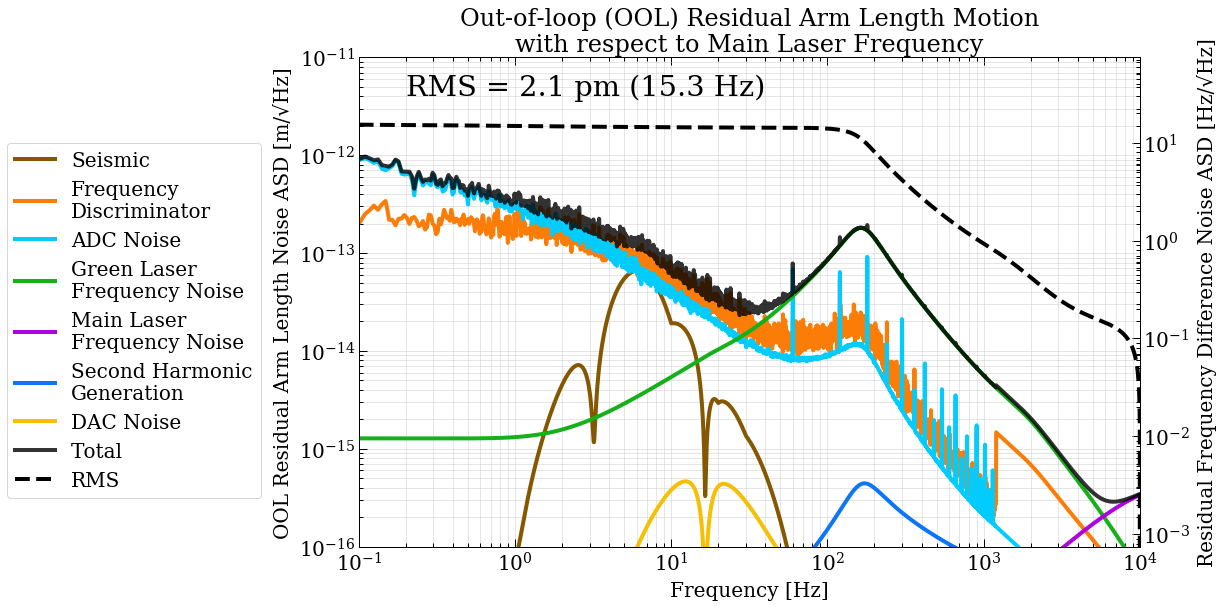

In [50]:
fig1, ax = plt.subplots(1,1, figsize=(14,9))

# Title
ax.set_title('Out-of-loop (OOL) Residual Arm Length Motion\n'
             'with respect to Main Laser Frequency')

# Noise curves
for key in ['Seismic', 'DFD', 'ADC',
            'AUX Residual Freq Noise',
            'PSL Residual Freq Noise',
            'SHG PSL',
            'DAC', 'Total', 'intTotal']:
    freq = ALSnb[key]['freq']
    trace = np.sqrt(ALSnb[key]['PSD'])
    style = ALSnb[key]['style']
    ax.plot(freq, trace, **style)
    
# Plot formatting
ax.set_xlim([freq[0], freq[-1]])
ax.set_ylim([1e-16, 1e-11])
ax.set_xlabel(u"Frequency [Hz]")
ax.set_ylabel(u"OOL Residual Arm Length Noise ASD [m/\u221AHz]")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(ncol=1, loc=(-0.45, 0.1));
ax.tick_params(right=False)
secaxy = ax.secondary_yaxis('right', functions=(mtoHz, Hztom))
secaxy.set_ylabel(u"Residual Frequency Difference Noise ASD [Hz/\u221AHz]")

RMSNoise = ALSnb['intTotal']['PSD'][0]**.5
RMSNoiseFreq = mtoHz(RMSNoise)
RMSstr = 'RMS = ' + str(np.round(RMSNoise*1e12, 1))+' pm ('+str(np.round(RMSNoiseFreq, 1))+' Hz)'

ax.text(0.2, RMSNoise*2, RMSstr, fontsize='x-large')
# Uncomment to save figure
#fig1.savefig('ALS_nb.pdf', bbox_inches='tight')